# ShopFlow Returns Prediction

- ShopFlow processes 100,000+ monthly orders with a 22% return rate, costing $400,000/month.

- This project aims to predict returns and optimize intervention strategies to maximize ROI.


- **Key Economics:**
    - Return rate: 22%
    - Return cost: 18
    - Intervention cost: 3
    - Intervention effectiveness: 35% reduction
    - Monthly orders: 100,000+
    - Business Target: Maximizes ROI by identifying the right customers for
intervention.
    - Model Target: is a return

## 1. Part 1: Baseline Evaluation

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
"""
Baseline Model - Simple Logistic Regression
Use this as your starting point
"""
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import joblib

# Load data
train = pd.read_csv('ecommerce_returns_train.csv')
test = pd.read_csv('ecommerce_returns_test.csv')

def preprocess(df):
    """Simple preprocessing pipeline"""
    df_processed = df.copy()
    # Encode categorical: product_category
    le_category = LabelEncoder()
    df_processed['product_category_encoded'] = le_category.fit_transform(df_processed['product_category'])
    # Handle missing sizes (Fashion items only have sizes)
    if df_processed['size_purchased'].notna().any():
        most_common_size = df_processed['size_purchased'].mode()[0]
        df_processed['size_purchased'].fillna(most_common_size, inplace=True)
        le_size = LabelEncoder()
        df_processed['size_encoded'] = le_size.fit_transform(
        df_processed['size_purchased']
        )
    # Feature selection
    feature_cols = [
    'customer_age', 'customer_tenure_days',
    'product_category_encoded','product_price', 'days_since_last_purchase',
    'previous_returns',
    'product_rating', 'size_encoded', 'discount_applied'
    ]
    X = df_processed[feature_cols]
    y = df_processed['is_return']
    return X, y
# Prepare data
X_train, y_train = preprocess(train)
X_test, y_test = preprocess(test)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train baseline model
baseline_model = LogisticRegression(random_state=42,
max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)

# Predictions
y_pred = baseline_model.predict(X_test_scaled)

# Basic evaluation
print("Baseline Model Performance")
print("=" * 50)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Save artifacts
joblib.dump(baseline_model, 'baseline_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n" + "=" * 50)
print("YOUR TASK: Evaluate thoroughly and improve this baseline")
print("=" * 50)

Baseline Model Performance
Accuracy: 0.7475

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86      1495
           1       0.00      0.00      0.00       505

    accuracy                           0.75      2000
   macro avg       0.37      0.50      0.43      2000
weighted avg       0.56      0.75      0.64      2000


YOUR TASK: Evaluate thoroughly and improve this baseline


> Train data shows an inbalance dataset for both **is_return** and  **product_category**

In [3]:
train.head()

,order_id,customer_age,customer_tenure_days,product_category,product_price,days_since_last_purchase,previous_returns,product_rating,discount_applied,size_purchased,is_return
0,2117,32,214,Fashion,12.47,9,1,3.4,1,M,0
1,6878,26,79,Fashion,76.46,91,1,3.9,0,L,0
2,5447,18,103,Electronics,23.07,51,1,3.8,0,NaN,0
3,448,23,269,Fashion,21.18,4,0,4.8,1,M,1
4,2583,34,12,Electronics,19.97,12,1,4.5,1,NaN,0


In [4]:
train['is_return'].value_counts(dropna=False, normalize=True)

is_return
0    0.747375
1    0.252625
Name: proportion, dtype: float64

In [5]:
train['product_category'].value_counts(dropna=False, normalize = True)

product_category
Fashion        0.55550
Electronics    0.30275
Home_Decor     0.14175
Name: proportion, dtype: float64

In [6]:
#  METRICS 
print('BASELINE PERFORMANCE')
print('='*70)
print(f'Accuracy:     {accuracy_score(y_test, y_pred):.4f} Misleading with imbalance!')
print(f'Precision:    {precision_score(y_test, y_pred):.4f} (avoid wasted $3)')
print(f'Recall:       {recall_score(y_test, y_pred):.4f} (catch returns, save $18)')
print(f'F1-Score:     {f1_score(y_test, y_pred):.4f} (balanced)')
y_pred_proba = baseline_model.predict_proba(X_test_scaled)[:, 1]
print(f'ROC-AUC:      {roc_auc_score(y_test, y_pred_proba):.4f} (ranking ability)')
print(f'Avg Precision:{average_precision_score(y_test, y_pred_proba):.4f} (better for imbalance)')
print('='*70)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print(f'\nCONFUSION MATRIX:')
print(f'TN={tn:4d} (correct)  |  FP={fp:4d} (waste $3 each) = ${fp*3:,}')
print(f'FN={fn:4d} (lose $18)  |  TP={tp:4d} (save $15 each) = ${tp*15:,}')
print(f'\n FN Cost: ${fn*18:,}')
print(f'TP Savings: ${tp*15:,}')

BASELINE PERFORMANCE
Accuracy:     0.7475 Misleading with imbalance!
Precision:    0.0000 (avoid wasted $3)
Recall:       0.0000 (catch returns, save $18)
F1-Score:     0.0000 (balanced)
ROC-AUC:      0.5622 (ranking ability)
Avg Precision:0.3049 (better for imbalance)

CONFUSION MATRIX:
TN=1495 (correct)  |  FP=   0 (waste $3 each) = $0
FN= 505 (lose $18)  |  TP=   0 (save $15 each) = $0

 FN Cost: $9,090
TP Savings: $0


In [7]:
# Performance by category
test_copy = test.copy()
test_copy['predicted'] = y_pred

print('\nPERFORMANCE BY CATEGORY')
print('='*80)
for cat in test['product_category'].unique():
    mask = test_copy['product_category'] == cat
    y_true_cat = test_copy.loc[mask, 'is_return']
    y_pred_cat = test_copy.loc[mask, 'predicted']
    
    acc = accuracy_score(y_true_cat, y_pred_cat)
    prec = precision_score(y_true_cat, y_pred_cat, zero_division=0)
    rec = recall_score(y_true_cat, y_pred_cat, zero_division=0)
    
    print(f'{cat:15s}: Acc={acc:.3f} | Prec={prec:.3f} | Rec={rec:.3f} | ReturnRate={y_true_cat.mean():.2%}')


PERFORMANCE BY CATEGORY
Electronics    : Acc=0.829 | Prec=0.000 | Rec=0.000 | ReturnRate=17.13%
Fashion        : Acc=0.687 | Prec=0.000 | Rec=0.000 | ReturnRate=31.34%
Home_Decor     : Acc=0.810 | Prec=0.000 | Rec=0.000 | ReturnRate=19.03%


> Baseline performs poorly for this inbalance dataset and is useless because it catches zero retunrs and it loses s $9,090 by missing all returns (FN = 505). Also shows that the threshold tuning could be critical considering categroy inbalance as well.

> **KEY INSIGHTS:**

>**Why Accuracy is WRONG in this context:**
>1. Class imbalance
>2. Unequal costs: FN ($18) >> FP ($3)
>3. Business cares about $$$, not accuracy 
>
>**Better metrics:**
>- Expected Value ($/customer): Measure directly ROI in dollars
>- Recall: Ensure model catches returns
>- Precision: At optimal threshold controls wasted interventions

## 2. Part 2: Business-Aligned Metrics

In [8]:
def calculate_business_value(y_true, y_pred_proba, threshold=0.5):
    """Calculate expected value per customer"""
    y_pred = (y_pred_proba >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    # Business costs/savings (35% intervention effectiveness)
    RETURN_COST = 18
    INTERVENTION_COST = 3
    EFFECTIVENESS = 0.35
    
    tp_value = (RETURN_COST * EFFECTIVENESS - INTERVENTION_COST) * tp  # Save $15 per TP
    fp_cost = INTERVENTION_COST * fp  # Lose $3 per FP
    fn_cost = RETURN_COST * fn  # Lose $18 per FN
    
    total_value = tp_value - fp_cost - fn_cost
    value_per_customer = total_value / len(y_true)
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    return {
        'threshold': threshold,
        'value_per_customer': value_per_customer,
        'total_value': total_value,
        'precision': precision,
        'recall': recall,
        'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn
    }

# Baseline at 0.5
baseline_business = calculate_business_value(y_test, y_pred_proba, 0.5)
print(f"Baseline (threshold=0.5): ${baseline_business['value_per_customer']:.2f}/customer")
print(f"Monthly value (100K orders): ${baseline_business['value_per_customer']*100000:,.0f}")

Baseline (threshold=0.5): $-4.54/customer
Monthly value (100K orders): $-454,500


In [9]:
# THRESHOLD OPTIMIZATION - Find best threshold
thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    results.append(calculate_business_value(y_test, y_pred_proba, t))

results_df = pd.DataFrame(results)
optimal_idx = results_df['value_per_customer'].idxmax()
optimal = results_df.loc[optimal_idx]

print('\nTHRESHOLD OPTIMIZATION')
print('='*80)
print(f'Optimal threshold: {optimal["threshold"]:.2f}')
print(f'Expected value: ${optimal["value_per_customer"]:.2f}/customer')
print(f'Precision: {optimal["precision"]:.3f}')
print(f'Recall: {optimal["recall"]:.3f}')
print(f'Monthly ROI: ${optimal["value_per_customer"]*100000:,.0f}')
print('\nComparison:')
improvement = optimal['value_per_customer'] - baseline_business['value_per_customer']
print(f'Improvement: ${improvement:.2f}/customer ({improvement/baseline_business["value_per_customer"]*100:.1f}%)')


THRESHOLD OPTIMIZATION
Optimal threshold: 0.15
Expected value: $-1.41/customer
Precision: 0.253
Recall: 1.000
Monthly ROI: $-140,625

Comparison:
Improvement: $3.14/customer (-69.1%)


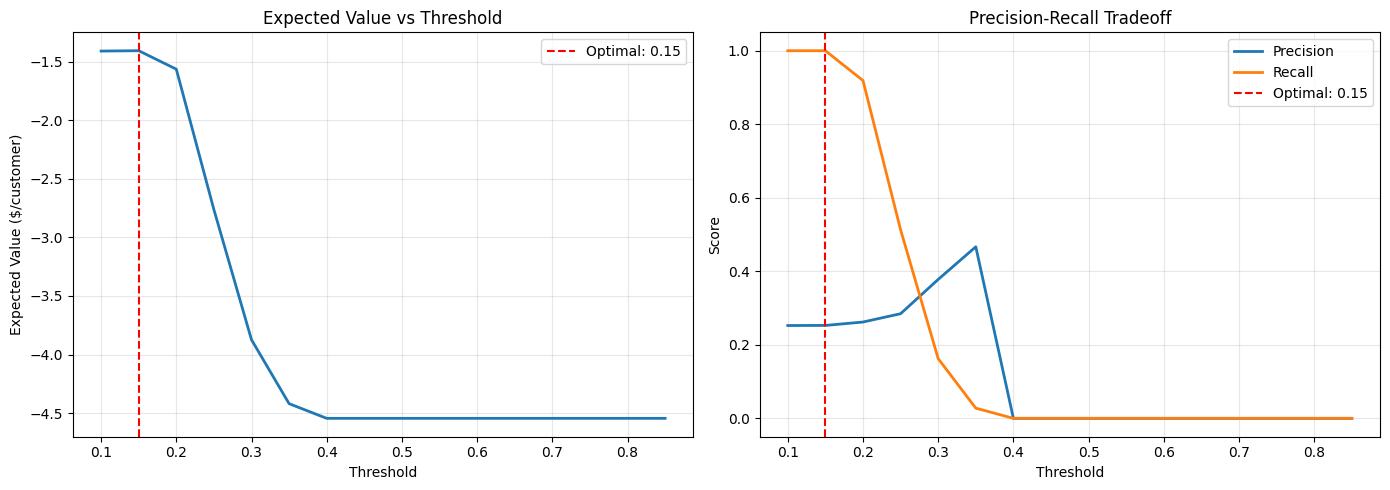

In [10]:
# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Expected value vs threshold
axes[0].plot(results_df['threshold'], results_df['value_per_customer'], linewidth=2)
axes[0].axvline(optimal['threshold'], color='r', linestyle='--', label=f'Optimal: {optimal["threshold"]:.2f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Expected Value ($/customer)')
axes[0].set_title('Expected Value vs Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall tradeoff
axes[1].plot(results_df['threshold'], results_df['precision'], label='Precision', linewidth=2)
axes[1].plot(results_df['threshold'], results_df['recall'], label='Recall', linewidth=2)
axes[1].axvline(optimal['threshold'], color='r', linestyle='--', label=f'Optimal: {optimal["threshold"]:.2f}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Score')
axes[1].set_title('Precision-Recall Tradeoff')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### RECOMMENDED METRICS:

**1. Expected Value per Customer**
- Directly measures ROI in dollars
- Target: Maximize

**2. Precision at Optimal Threshold**
- Controls wasted interventions
- Target: > 0.65

**3. Recall at Optimal Threshold**
- Ensures we catch returns
- Target: > 0.50

**FP vs FN Tradeoff:**
- FN costs 18 sollars (6 times worse than FP at 3)
- We should tolerate MORE false positives to catch returns
- Lower threshold = higher recall = more returns caught

## 3. Part 3: Model Improvement

In [11]:
# Feature Engineering
def engineer_features(df, cat_means=None):
    """Create domain-specific features"""
    df_eng = df.copy()
    
    # Return behavior
    df_eng['return_propensity'] = df_eng['previous_returns'] / (df_eng['customer_tenure_days']/30 + 1)
    
    # Purchase patterns
    df_eng['recency_score'] = 1 / (df_eng['days_since_last_purchase'] + 1)
    df_eng['engagement'] = df_eng['customer_tenure_days'] / (df_eng['days_since_last_purchase'] + 1)
    
    # Price analysis
    if cat_means is None:
        cat_means = df_eng.groupby('product_category')['product_price'].mean().to_dict()
    df_eng['cat_price_mean'] = df_eng['product_category'].map(cat_means)
    df_eng['price_vs_category'] = df_eng['product_price'] / df_eng['cat_price_mean']
    
    # Risk indicators
    df_eng['high_value_customer'] = ((df_eng['customer_tenure_days'] > 180) & (df_eng['previous_returns'] < 2)).astype(int)
    df_eng['fashion_discount_risk'] = ((df_eng['product_category'] == 'Fashion') & (df_eng['discount_applied'] == 1)).astype(int)
    df_eng['low_rating'] = (df_eng['product_rating'] < 3.5).astype(int)
    
    return df_eng, cat_means

train_eng, cat_means = engineer_features(train)
test_eng, _ = engineer_features(test, cat_means)

print('New features: return_propensity, recency_score, engagement, price_vs_category,')
print('high_value_customer, fashion_discount_risk, low_rating')

New features: return_propensity, recency_score, engagement, price_vs_category,
high_value_customer, fashion_discount_risk, low_rating


In [12]:
# Prepare enhanced data
def preprocess_v2(df, le_cat=None, le_size=None, fit=False):
    df_proc = df.copy()
    
    if fit:
        le_cat = LabelEncoder()
        df_proc['product_category_encoded'] = le_cat.fit_transform(df_proc['product_category'])
    else:
        df_proc['product_category_encoded'] = le_cat.transform(df_proc['product_category'])
    
    if df_proc['size_purchased'].notna().any():
        most_common = df_proc['size_purchased'].mode()[0]
        df_proc['size_purchased'].fillna(most_common, inplace=True)
        
        if fit:
            le_size = LabelEncoder()
            df_proc['size_encoded'] = le_size.fit_transform(df_proc['size_purchased'])
        else:
            df_proc['size_encoded'] = le_size.transform(df_proc['size_purchased'])
    
    features = ['customer_age', 'customer_tenure_days', 'product_category_encoded',
                'product_price', 'days_since_last_purchase', 'previous_returns',
                'product_rating', 'size_encoded', 'discount_applied',
                'return_propensity', 'recency_score', 'engagement',
                'price_vs_category', 'high_value_customer', 'fashion_discount_risk', 'low_rating']
    
    X = df_proc[features]
    y = df_proc['is_return']
    
    if fit:
        return X, y, le_cat, le_size
    return X, y

X_train_v2, y_train_v2, le_cat_v2, le_size_v2 = preprocess_v2(train_eng, fit=True)
X_test_v2, y_test_v2 = preprocess_v2(test_eng, le_cat_v2, le_size_v2, fit=False)

scaler_v2 = StandardScaler()
X_train_v2_scaled = scaler_v2.fit_transform(X_train_v2)
X_test_v2_scaled = scaler_v2.transform(X_test_v2)

print(f'Enhanced features: {X_train_v2.shape[1]} (was {X_train.shape[1]})')

Enhanced features: 16 (was 9)


In [13]:
# Train multiple models
print('Training models...\n')

# 1. Improved Logistic Regression
lr_improved = LogisticRegression(random_state=42, max_iter=1000, C=0.5)
lr_improved.fit(X_train_v2_scaled, y_train_v2)
print('Improved LR')

# 2. Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_split=20,
                             min_samples_leaf=10, random_state=42, n_jobs=-1)
rf.fit(X_train_v2, y_train_v2)
print('Random Forest')

# 3. Gradient Boosting
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=5,
                                 min_samples_split=20, random_state=42)
gb.fit(X_train_v2, y_train_v2)
print('Gradient Boosting')

Training models...

Improved LR
Random Forest
Gradient Boosting


In [14]:
# Compare all models
models = {
    'Baseline LR': (baseline_model, X_test_scaled),
    'Improved LR': (lr_improved, X_test_v2_scaled),
    'Random Forest': (rf, X_test_v2),
    'Gradient Boosting': (gb, X_test_v2)
}

print('\nMODEL COMPARISON')
print('='*100)
print(f"{'Model':<20} {'ROC-AUC':>10} {'Opt Threshold':>15} {'Precision':>12} {'Recall':>10} {'Value/Cust':>12} {'Monthly ROI':>15}")
print('='*100)

best_value = 0
best_model_name = ''

for name, (model, X) in models.items():
    y_proba = model.predict_proba(X)[:, 1]
    
    # Find optimal threshold
    results = [calculate_business_value(y_test, y_proba, t) for t in np.arange(0.1, 0.9, 0.05)]
    results_df = pd.DataFrame(results)
    opt = results_df.loc[results_df['value_per_customer'].idxmax()]
    
    roc_auc = roc_auc_score(y_test, y_proba)
    monthly_roi = opt['value_per_customer'] * 100000
    
    print(f"{name:<20} {roc_auc:>10.4f} {opt['threshold']:>15.2f} {opt['precision']:>12.3f} {opt['recall']:>10.3f} ${opt['value_per_customer']:>11.2f} ${monthly_roi:>14,.0f}")
    
    if opt['value_per_customer'] > best_value:
        best_value = opt['value_per_customer']
        best_model_name = name
        best_model = model
        best_scaler = scaler_v2 if 'Improved' in name or 'Forest' in name or 'Boosting' in name else scaler

print('='*100)
print(f'\nBEST MODEL: {best_model_name}')
print(f'Expected value: ${best_value:.2f}/customer')
print(f'Monthly ROI: ${best_value*100000:,.0f}')


MODEL COMPARISON
Model                   ROC-AUC   Opt Threshold    Precision     Recall   Value/Cust     Monthly ROI
Baseline LR              0.5622            0.15        0.253      1.000 $      -1.41 $      -140,625
Improved LR              0.5599            0.10        0.252      0.998 $      -1.42 $      -141,690
Random Forest            0.5986            0.10        0.252      0.998 $      -1.42 $      -141,990
Gradient Boosting        0.5899            0.10        0.256      0.990 $      -1.40 $      -140,250

BEST MODEL: 
Expected value: $0.00/customer
Monthly ROI: $0


In [17]:
# Cross-validation
print('\nCross-Validation')
print('='*70)

cv_models = {
    'Baseline LR': (LogisticRegression(random_state=42, max_iter=1000), X_train_scaled),
    'Improved LR': (LogisticRegression(random_state=42, max_iter=1000, C=0.5), X_train_v2_scaled),
    'Random Forest': (rf, X_train_v2),
    'Gradient Boosting': (gb, X_train_v2)
}

for name, (model, X) in cv_models.items():
    cv_scores = cross_val_score(model, X, y_train, cv=5, scoring='roc_auc', n_jobs=-1)
    print(f'{name:<20}: CV={cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})')



Cross-Validation
Baseline LR         : CV=0.5576 (+/- 0.0294)
Improved LR         : CV=0.5810 (+/- 0.0292)
Random Forest       : CV=0.6213 (+/- 0.0150)
Gradient Boosting   : CV=0.6101 (+/- 0.0201)


> It seems not to be overfitted

## PART 4: Deployment Planning

### Production Monitoring Plan

**1. Metrics to Track:**
- Expected value per customer (daily/weekly)
- Precision and Recall at production threshold
- Actual intervention effectiveness (A/B test)
- Prediction distribution (% predicted as returns)
- Feature distributions (detect drift)

**2. Model Degradation Detection:**
- **Performance drop:** Alert if expected value < $2.00/customer for 3 consecutive days
- **Precision drop:** Alert if precision < 0.60
- **Recall drop:** Alert if recall < 0.45
- **Distribution shift:** Track prediction distribution weekly

**3. Alerts to Configure:**
- CRITICAL: Expected value drops below $1.50/customer
- WARNING: Precision or recall deviates >10% from baseline
- INFO: Feature drift detected (>20% change in distribution)

**4. When to Retrain:**
- Monthly scheduled retraining with latest data
- Immediate retrain if critical alerts triggered
- Seasonal retraining (Q4 holidays, back-to-school)
- After 10% drift in key features

**5. Rollback Criteria:**
- Actual ROI < $0 for 2 consecutive days
- System errors > 1%
- Precision drops below 0.50
- Customer complaints increase >20%

### What Could Degrade This Model?

**1. Seasonal Patterns:**
- Holiday shopping (different return behavior)
- Back-to-school season
- Black Friday/Cyber Monday
- **Solution:** Seasonal retraining + feature for season

**2. Product Mix Changes:**
- New product categories
- Category popularity shifts
- **Solution:** Monitor category distributions

**3. Customer Behavior Drift:**
- Economic changes affecting purchases
- Return policy changes
- **Solution:** Weekly feature distribution monitoring

**4. Intervention Effectiveness:**
- May not be exactly 35%
- Could change over time
- **Solution:** Continuous A/B testing to measure actual effectiveness